<a href="https://www.kaggle.com/code/udaiveersinghsdjab/wildlife-classification-using-efficientnet?scriptVersionId=238312379" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# For data preprocessing
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.data import AUTOTUNE

# For model 
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers, losses, callbacks, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Define base directory
BASE_DIR = "/kaggle/input/wildlife-classification"

# Define paths
TRAIN_CSV_PATH = os.path.join(BASE_DIR, "train_features.csv")
TEST_CSV_PATH = os.path.join(BASE_DIR, "test_features.csv")
LABELS_CSV_PATH = os.path.join(BASE_DIR, "train_labels.csv")
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train_features")
TEST_IMG_DIR = os.path.join(BASE_DIR, "test_features")

In [3]:
train_features = pd.read_csv(TRAIN_CSV_PATH)
test_features = pd.read_csv(TEST_CSV_PATH)
train_labels = pd.read_csv(LABELS_CSV_PATH)

# Display first few rows
print(train_features.head())
print(train_labels.head())

         id                     filepath   site
0  ZJ000000  train_features/ZJ000000.jpg  S0120
1  ZJ000001  train_features/ZJ000001.jpg  S0069
2  ZJ000002  train_features/ZJ000002.jpg  S0009
3  ZJ000003  train_features/ZJ000003.jpg  S0008
4  ZJ000004  train_features/ZJ000004.jpg  S0036
         id  antelope_duiker  bird  blank  civet_genet  hog  leopard  \
0  ZJ000000              0.0   1.0    0.0          0.0  0.0      0.0   
1  ZJ000001              0.0   0.0    0.0          0.0  0.0      0.0   
2  ZJ000002              0.0   1.0    0.0          0.0  0.0      0.0   
3  ZJ000003              0.0   0.0    0.0          0.0  0.0      0.0   
4  ZJ000004              0.0   0.0    0.0          0.0  0.0      1.0   

   monkey_prosimian  rodent  
0               0.0     0.0  
1               1.0     0.0  
2               0.0     0.0  
3               1.0     0.0  
4               0.0     0.0  


In [4]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'id',
 'leopard',
 'monkey_prosimian',
 'rodent']

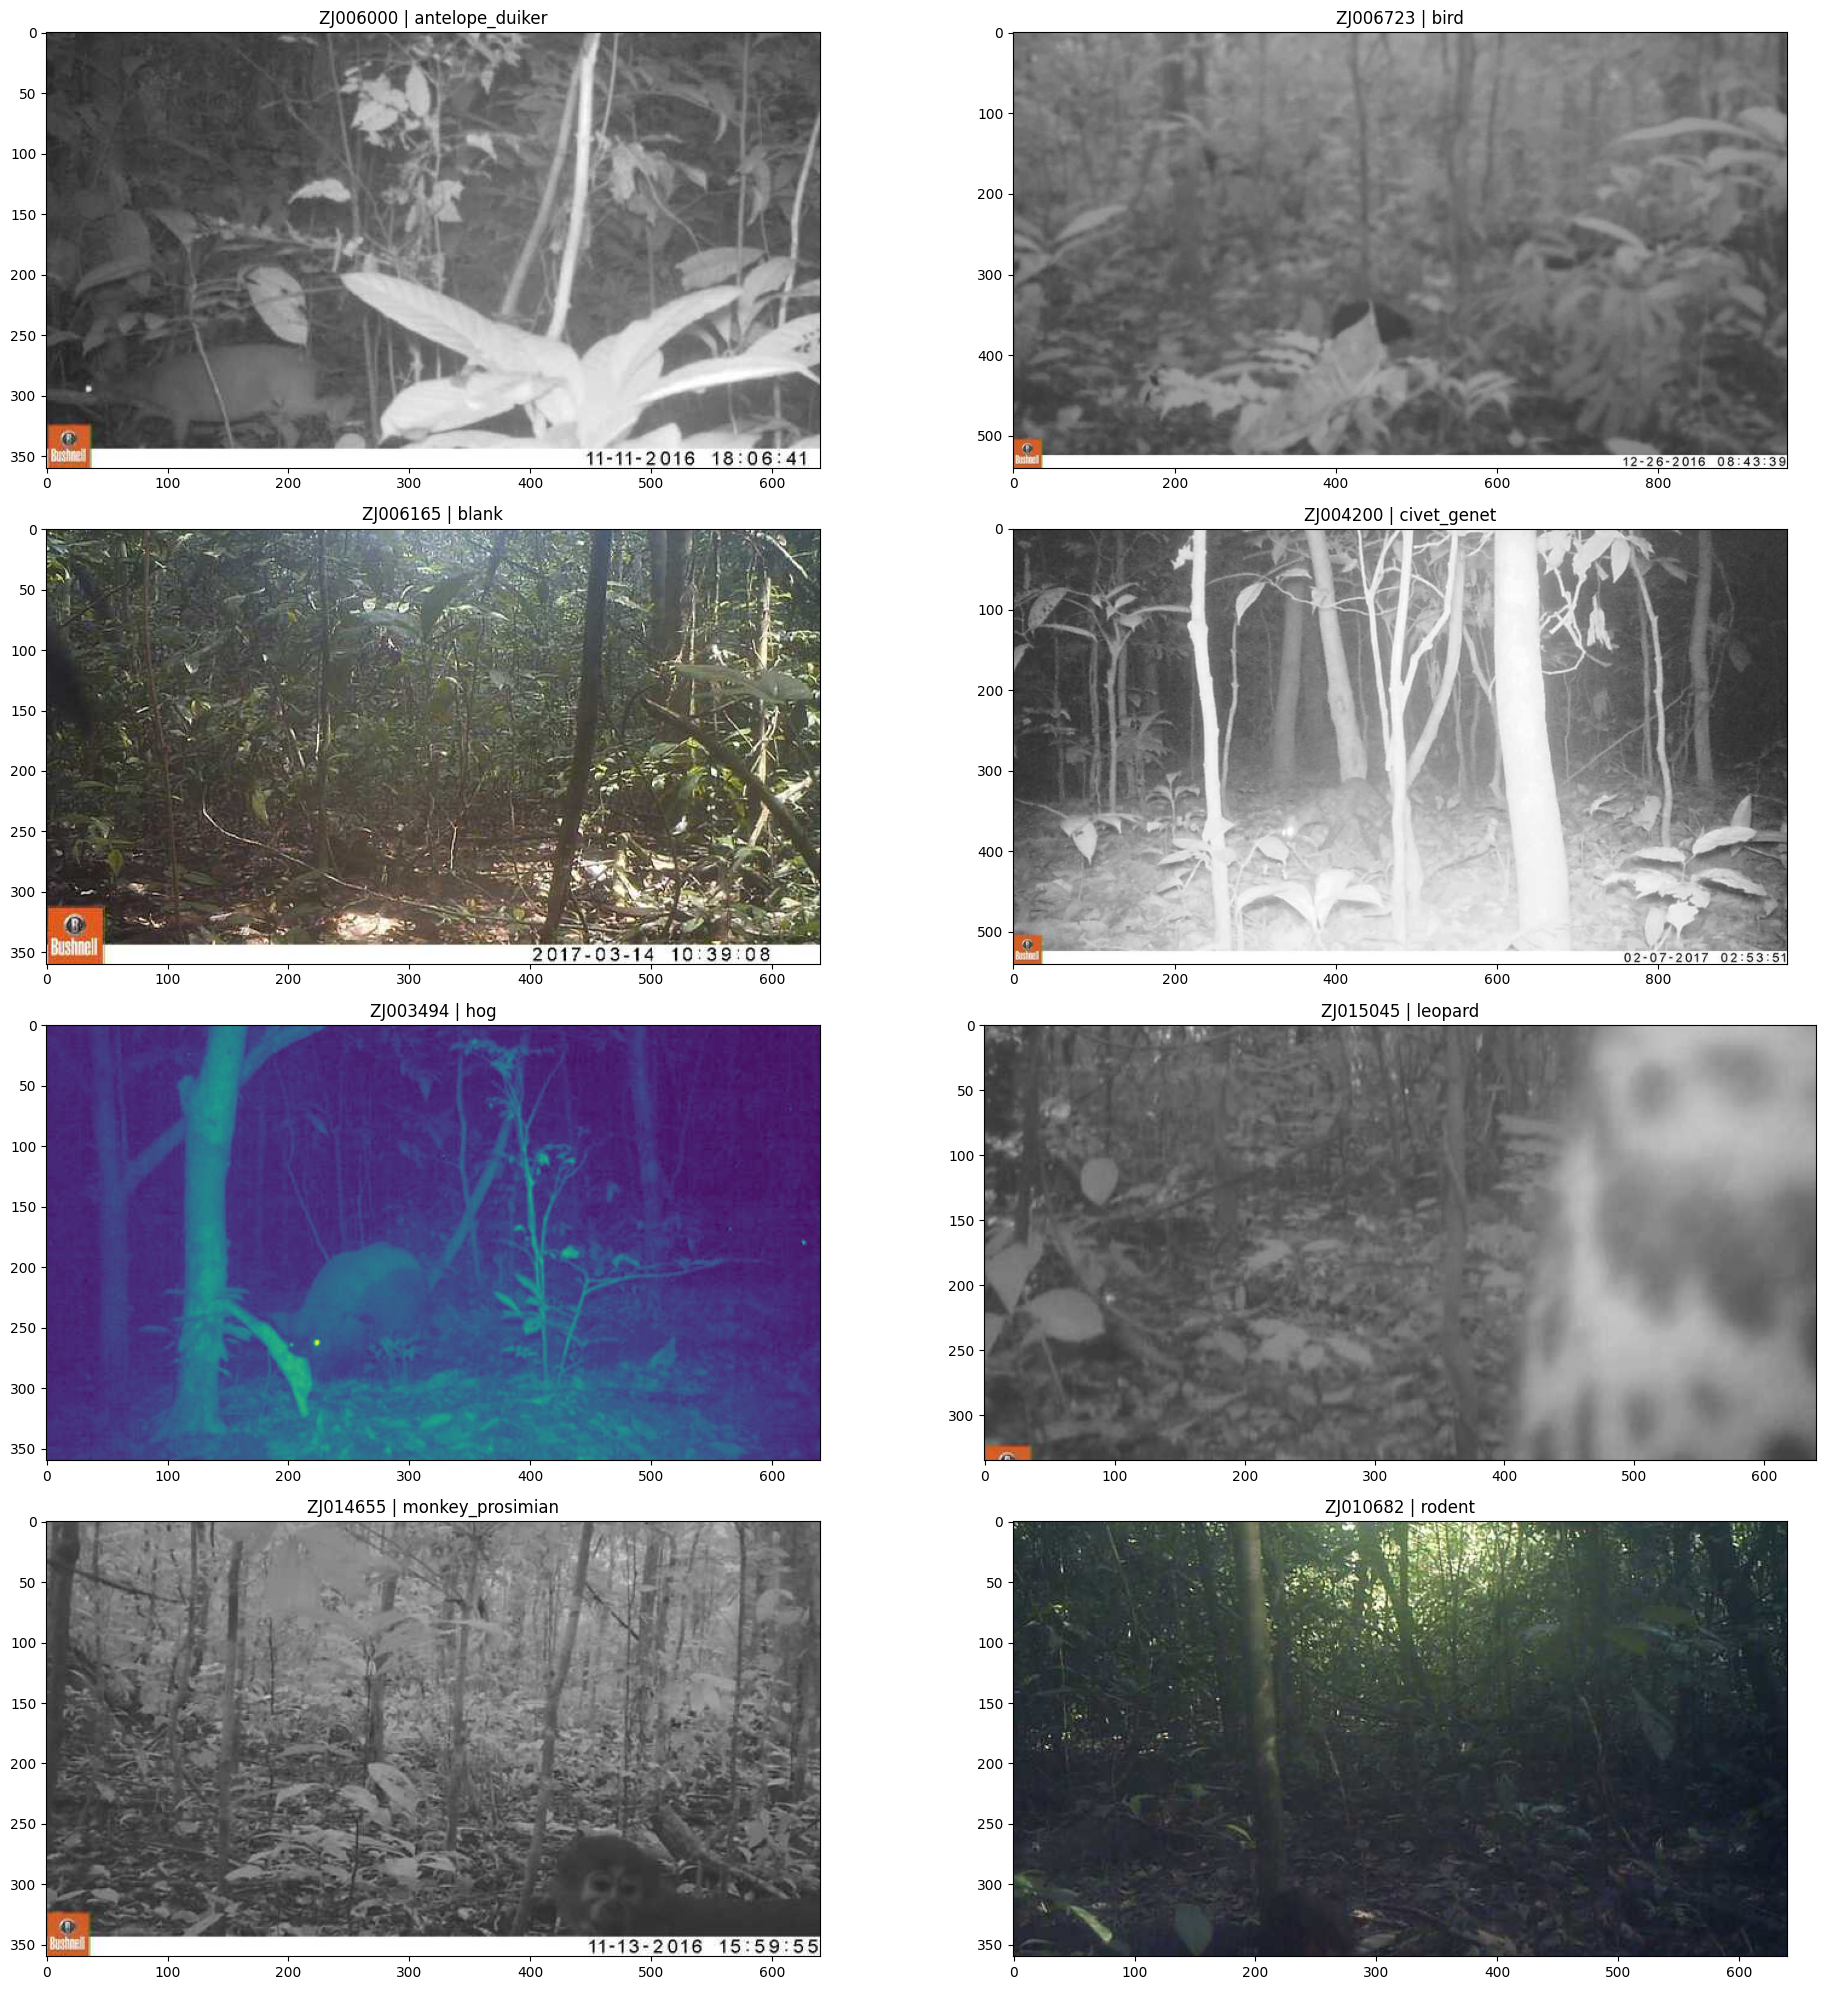

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

random_state = 42

# Define the correct species labels from train_labels.csv
species_labels = train_labels.columns[1:]  # Exclude 'id' column

# Create a grid with 8 positions, one for each label (7 species + blank)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# Iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # Get all images for the species
    species_images = train_labels[train_labels[species] == 1]

    # Skip if no images exist for this species
    if species_images.empty:
        ax.set_title(f"No images for {species}")
        ax.axis("off")  # Hide axis if no image is available
        continue

    # Sample one image ID from available images
    img_id = species_images.sample(1, random_state=random_state).id.values[0]
    
    # Get the correct file path
    img_path = os.path.join(BASE_DIR, train_features[train_features["id"] == img_id]["filepath"].values[0])
    
    # Read and plot the image
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

plt.tight_layout()
plt.show()

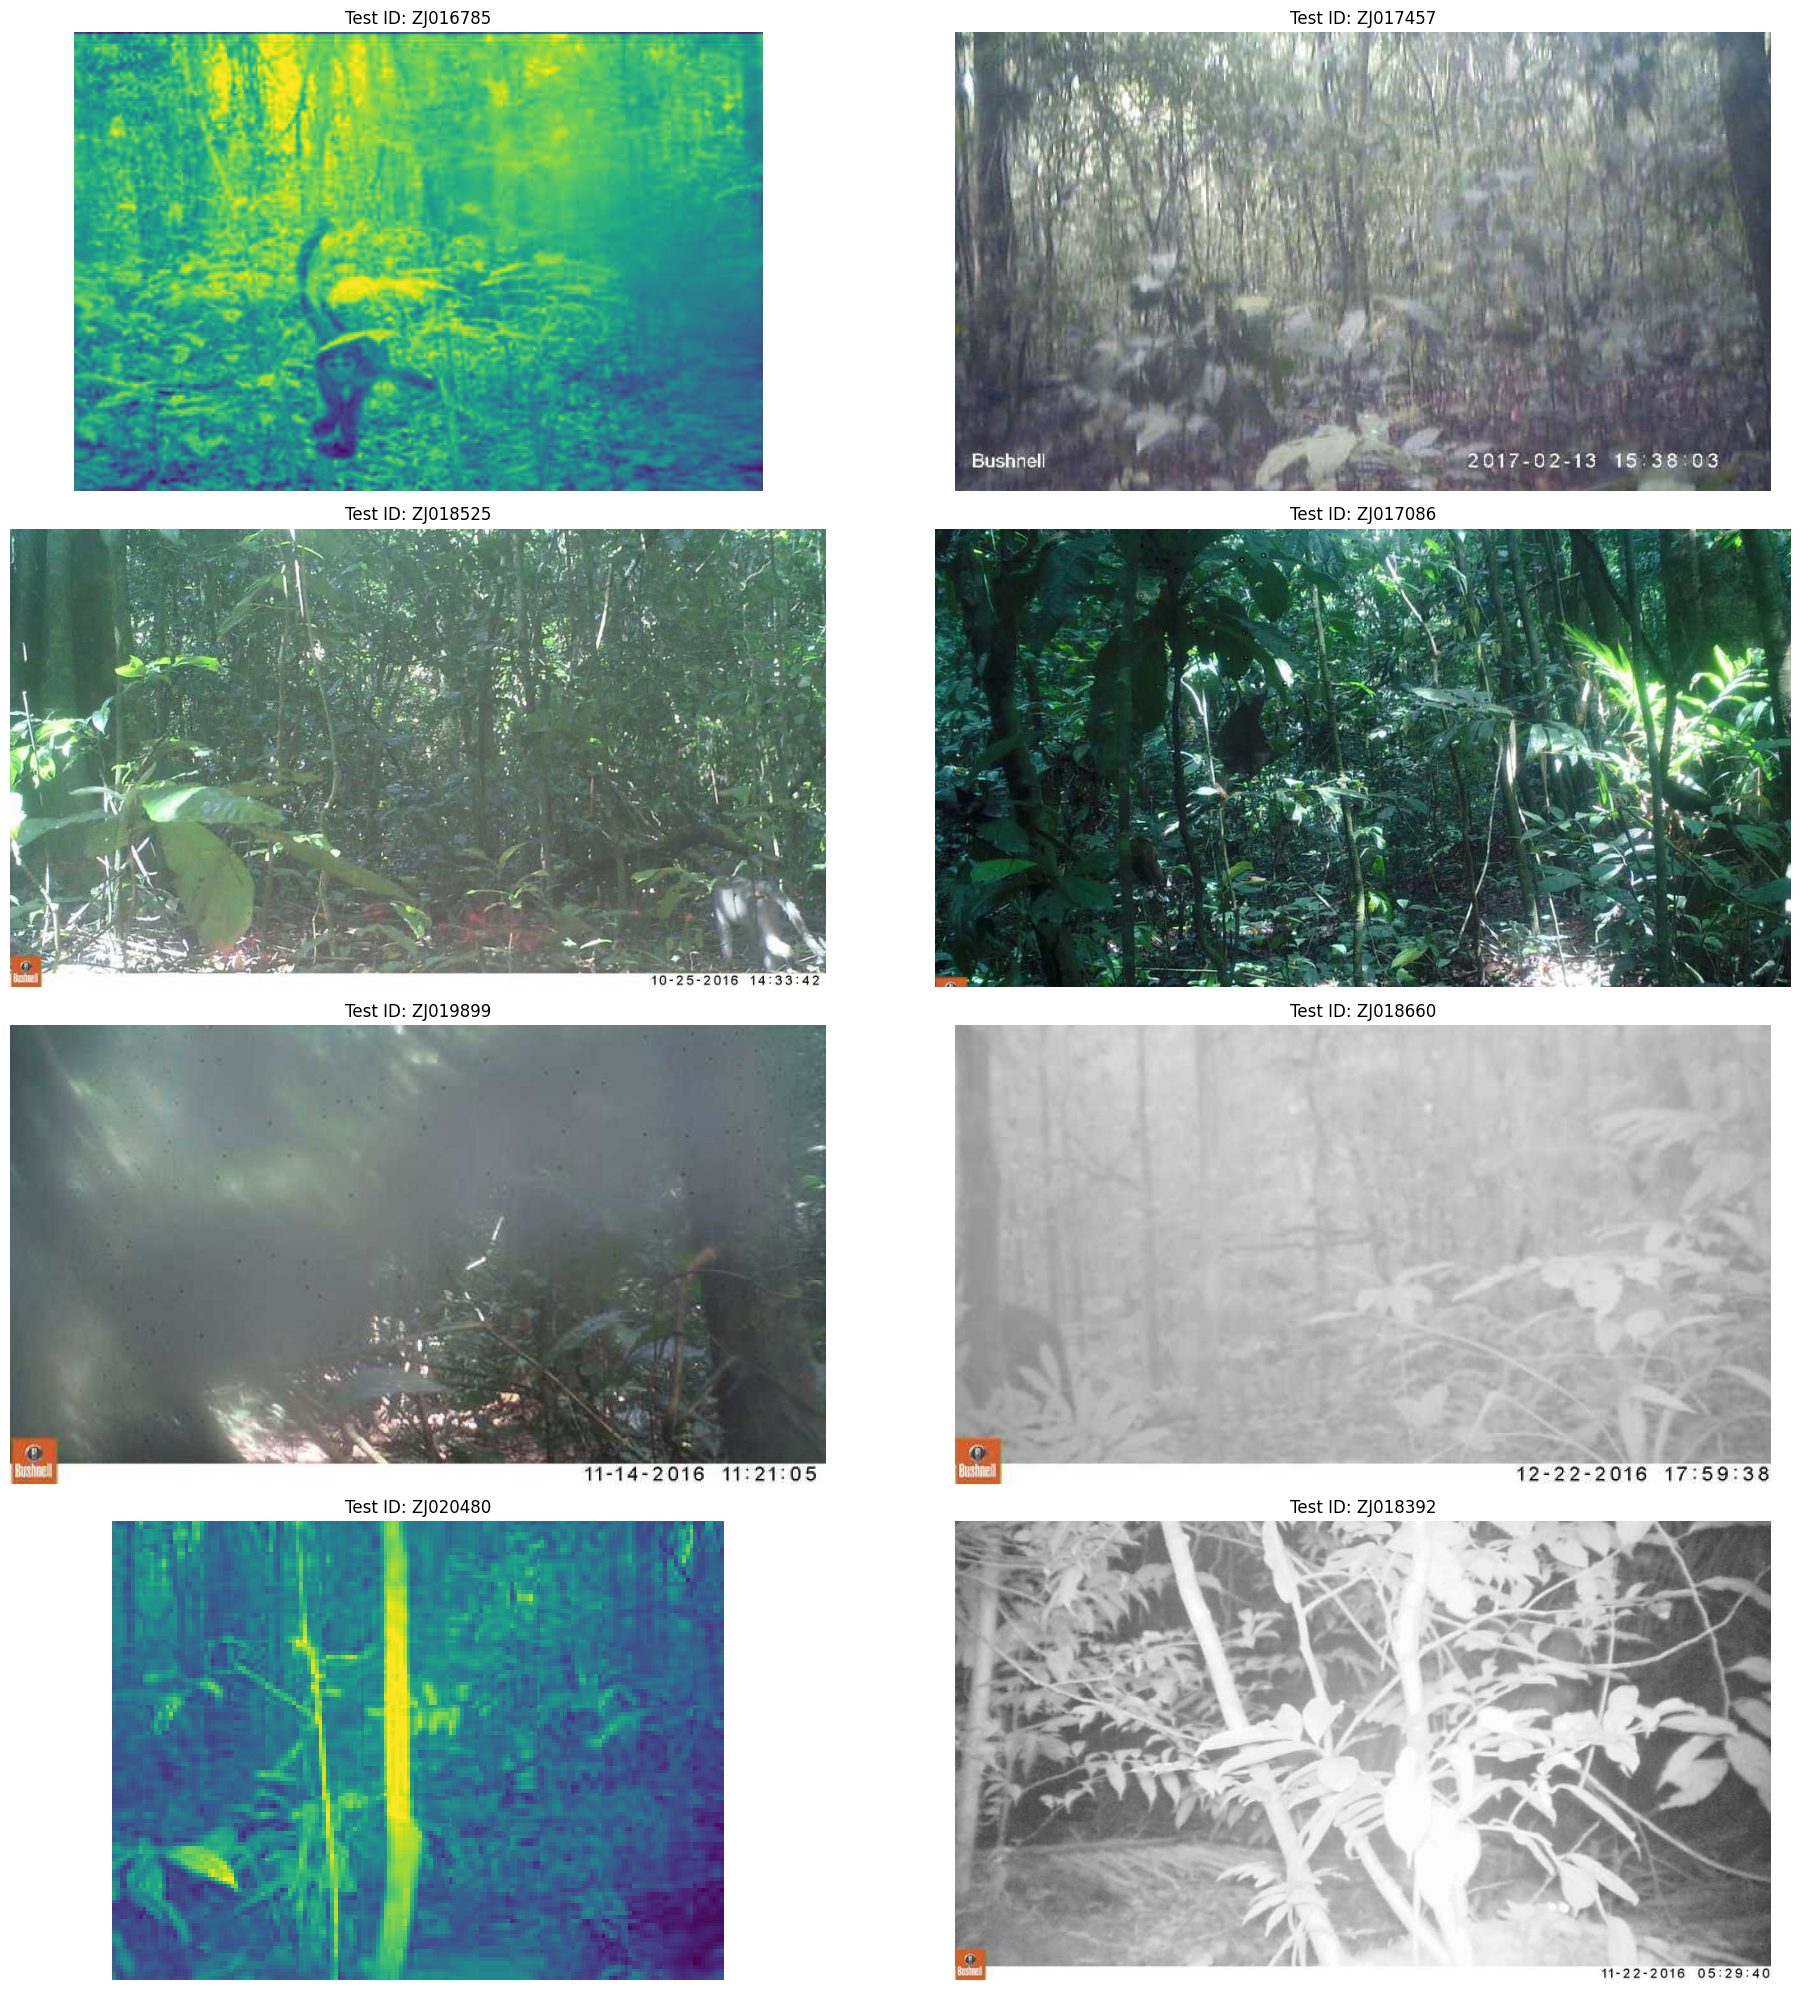

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

random_state = 42

# Sample 8 random test images
sampled_test = test_features.sample(8, random_state=random_state)

# Create a 4x2 grid for visualization
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# Loop over the samples and plot each image
for (idx, row), ax in zip(sampled_test.iterrows(), axes.flat):
    img_id = row["id"]
    img_path = os.path.join(BASE_DIR, row["filepath"])
    
    # Read and plot the image
    try:
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(f"Test ID: {img_id}")
        ax.axis("off")
    except Exception as e:
        ax.set_title(f"Could not load {img_id}")
        ax.axis("off")

plt.tight_layout()
plt.show()

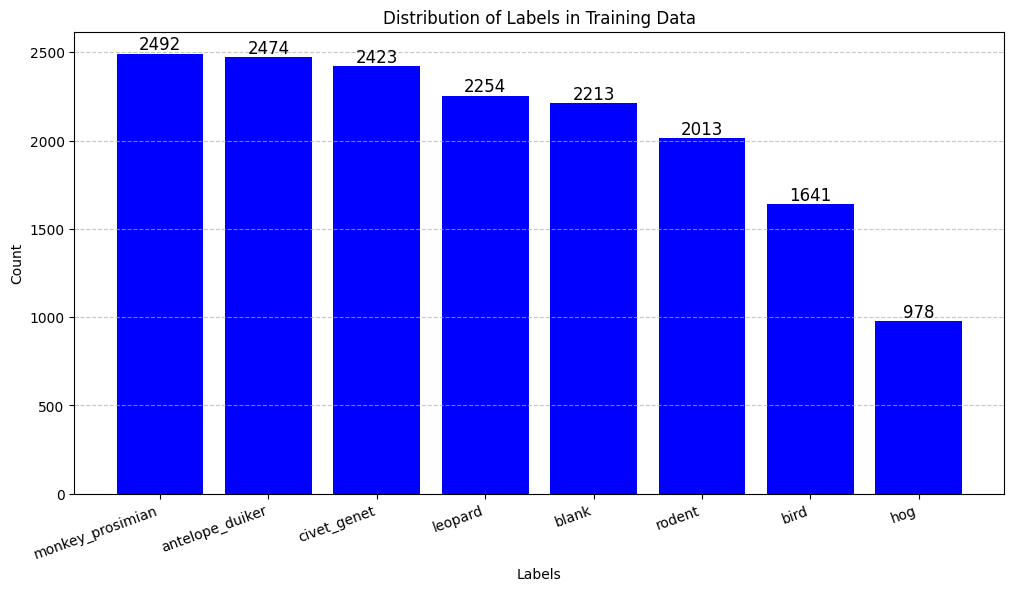

In [7]:
# Ensure we sum only numeric columns
numeric_labels = train_labels.select_dtypes(include=['number'])

# Sum occurrences of each label
label_counts = numeric_labels.sum().sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.index, label_counts.values, color='blue')

# Annotate bars with their values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12)

# Labels and title
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Distribution of Labels in Training Data")
plt.xticks(rotation=20, ha='right')  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [9]:
# Merge train features with labels
df = train_features.merge(train_labels, on="id", how="left")
# Drop rows with missing labels
df.dropna(inplace=True)
# Find the label for each image (the column where the value is 1)
label_columns = train_labels.columns[1:]  # Excluding the 'id' column
# Ensure labels are in one-hot encoded format
labels_one_hot = df[label_columns].to_numpy().astype(np.float32)

In [10]:
# Extract Image Paths
df["image_path"] = df["id"].apply(lambda x: os.path.join(TRAIN_IMG_DIR, f"{x}.jpg"))
image_paths = df["image_path"].values

# Extract test image paths from test_features
test_features["image_path"] = test_features["id"].apply(lambda x: os.path.join(TEST_IMG_DIR, f"{x}.jpg"))
test_paths = test_features["image_path"].values

In [11]:
# Split into Training and Validation Sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels_one_hot, test_size=0.2, stratify=labels_one_hot, random_state=42
)

print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)

Train labels shape: (13190, 8)
Validation labels shape: (3298, 8)


In [12]:
# Image size required for EfficientNet
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Function to load and preprocess images
def load_image(image_path, label=None):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure RGB
    image = tf.image.resize(image, IMG_SIZE)  # Resize to EfficientNet input size  
    image = preprocess_input(image)
    # Return (image, label) for training, (image) for test
    return (image, label) if label is not None else image

def gaussian_blur(image, kernel_size=5, sigma=1.0):
    def _gaussian_kernel(size, sigma):
        x = tf.range(-size // 2 + 1, size // 2 + 1, dtype=tf.float32)
        x = tf.exp(-0.5 * tf.square(x) / tf.square(sigma))
        kernel = tf.tensordot(x, x, axes=0)
        kernel /= tf.reduce_sum(kernel)
        return kernel[:, :, tf.newaxis, tf.newaxis]

    kernel = _gaussian_kernel(kernel_size, sigma)
    kernel = tf.repeat(kernel, repeats=3, axis=2)  # For RGB
    image = tf.expand_dims(image, axis=0)  # Add batch dim
    image = tf.nn.depthwise_conv2d(image, kernel, strides=[1, 1, 1, 1], padding='SAME')
    return tf.squeeze(image, axis=0)  # Remove batch dim

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.2)
    
    # Randomly darken image
    if tf.random.uniform([]) < 0.5:
        image = tf.image.adjust_brightness(image, -0.2)
    
    # Randomly apply blur
    if tf.random.uniform([]) < 0.3:
        image = gaussian_blur(image)

    return image, label

In [13]:
# Create training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_image, num_parallel_calls=AUTOTUNE)  # Load images
train_dataset = train_dataset.map(augment, num_parallel_calls=AUTOTUNE)  # Augment training data
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create validation dataset (no augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_image, num_parallel_calls=AUTOTUNE)  # Load images
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create test dataset (no labels, no augmentation)
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)  
test_dataset = test_dataset.map(load_image, num_parallel_calls=AUTOTUNE)  # Load images
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Datasets prepared successfully!")

Datasets prepared successfully!


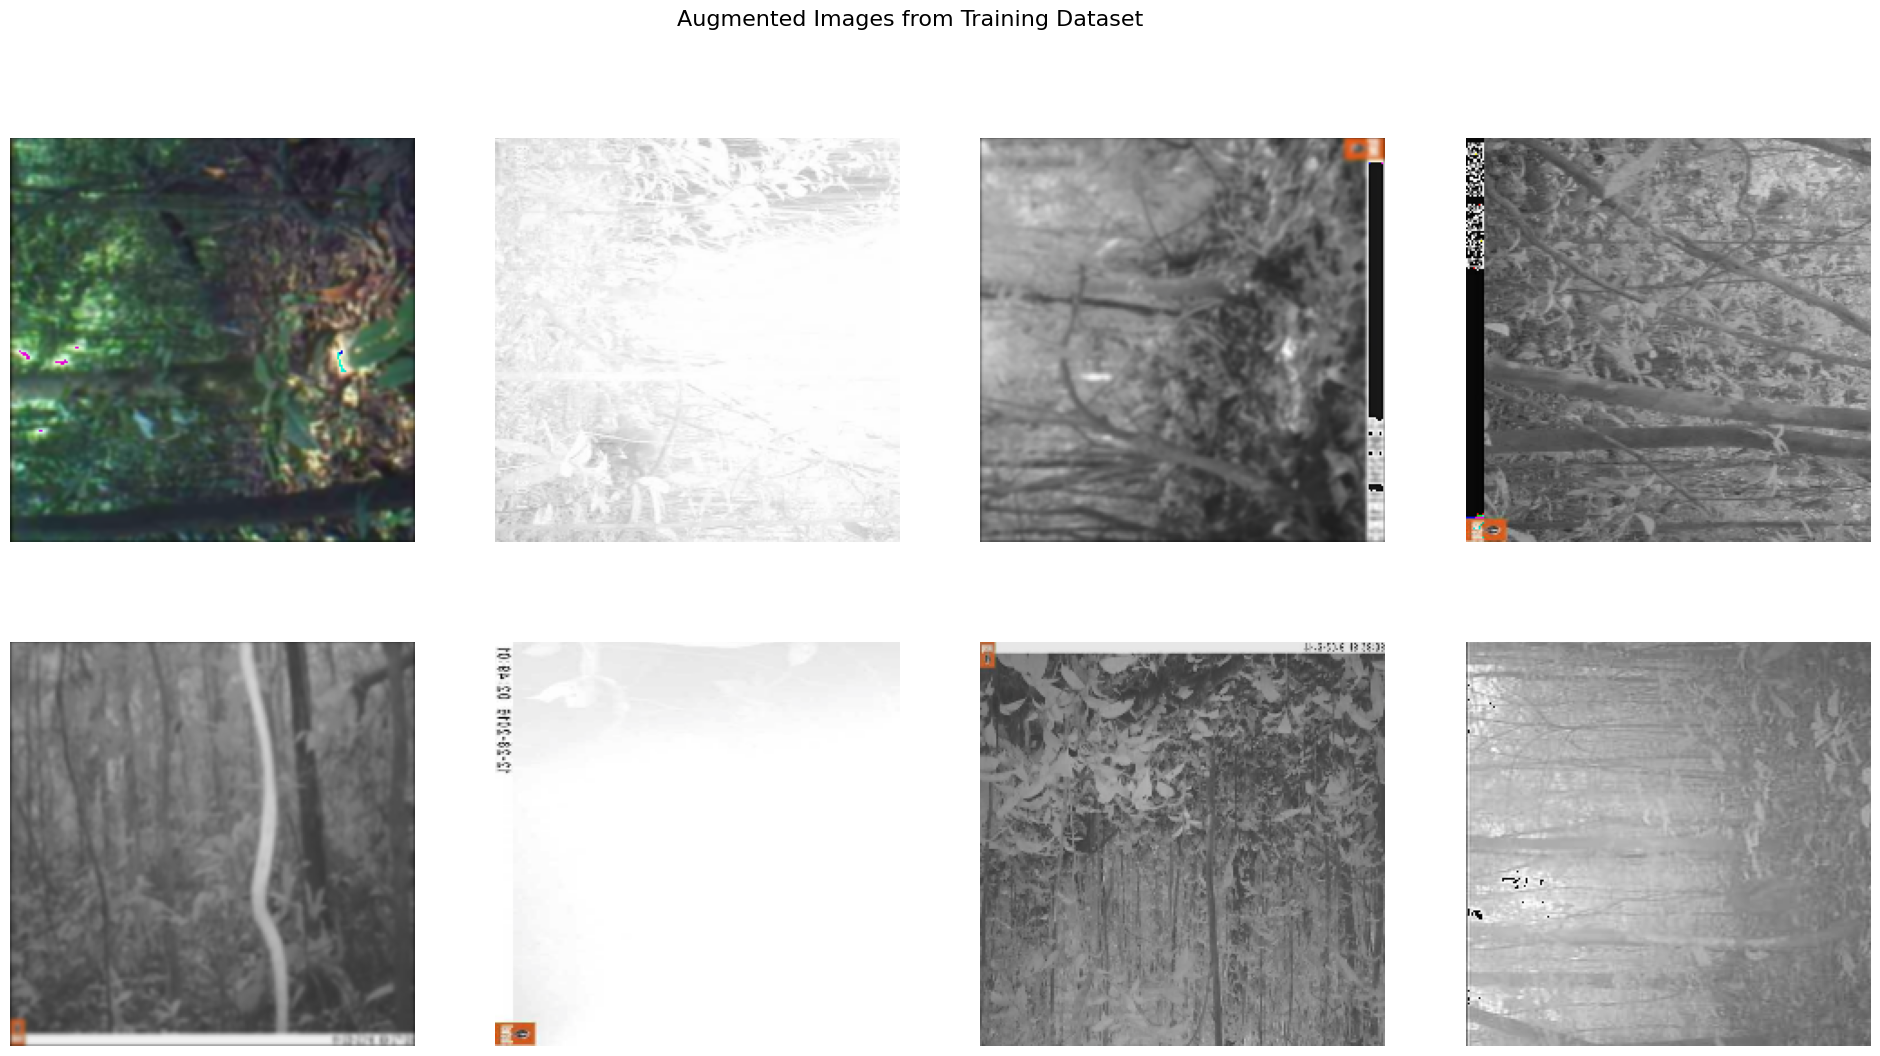

In [14]:
import matplotlib.pyplot as plt

# Fetch a batch of images and labels from the dataset
sample_batch = next(iter(train_dataset))  # Get one batch
sample_images, sample_labels = sample_batch  # Unpack images and labels

# Convert tensor to numpy array
sample_images = sample_images.numpy()

# Define number of images to show
num_images = min(8, sample_images.shape[0])  # Show up to 8 images

# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(sample_images[i].astype("uint8"))  # Convert tensor to uint8 image
        ax.axis("off")
    else:
        ax.remove()

plt.suptitle("Augmented Images from Training Dataset", fontsize=16)
plt.show()

In [15]:
# Load EfficientNetB0 (Pretrained on ImageNet, without top layers)
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

base_model.trainable = True  # Unfreeze all layers
# Freeze all but the last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Convert feature maps to vector
    layers.Dense(1024, activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),  # Dropout to reduce overfitting
    # layers.Dense(512, activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001)),
    # layers.Dropout(0.4),  # Dropout to reduce overfitting
    layers.Dense(8, activation="softmax")  # Output layer for multi-class classification
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# from tensorflow.keras import layers, models, regularizers

# def build_enhanced_cnn(input_shape=(224, 224, 3), num_classes=8):
#     inputs = layers.Input(shape=input_shape)

#     # Block 1
#     x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.MaxPooling2D(pool_size=(2, 2))(x)
#     x = layers.Dropout(0.25)(x)

#     # Block 2 with Residual Connection
#     shortcut = layers.Conv2D(128, (1, 1), padding='same', kernel_initializer='he_normal')(x)  # Match filters
#     shortcut = layers.BatchNormalization()(shortcut)

#     x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Add()([x, shortcut])  # Residual connection


#     # Block 3 with Depthwise Separable Convolutions
#     x = layers.SeparableConv2D(256,(3, 3),padding='same',depthwise_initializer='he_normal',pointwise_initializer='he_normal')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.SeparableConv2D(256,(3, 3),padding='same',depthwise_initializer='he_normal',pointwise_initializer='he_normal')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.MaxPooling2D(pool_size=(2, 2))(x)
#     x = layers.Dropout(0.4)(x)

#     # Global Average Pooling
#     x = layers.GlobalAveragePooling2D()(x)

#     # Fully Connected Layers
#     x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)
#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     model = models.Model(inputs=inputs, outputs=outputs)
#     return model

# # Instantiate the model
# model = build_enhanced_cnn()

In [16]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,369,515 (20.48 MB)

 Trainable params: 2,816,104 (10.74 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

In [17]:
# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", mode="min")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Adjust based on performance
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 112s 401ms/step - accuracy: 0.4758 - loss: 3.1259 - val_accuracy: 0.6656 - val_loss: 1.7735 - learning_rate: 0.0010
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 201ms/step - accuracy: 0.6426 - loss: 1.6742 - val_accuracy: 0.7365 - val_loss: 1.1412 - learning_rate: 0.0010
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 202ms/step - accuracy: 0.6987 - loss: 1.1675 - val_accuracy: 0.7592 - val_loss: 0.9048 - learning_rate: 0.0010
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 203ms/step - accuracy: 0.7408 - loss: 0.9198 - val_accuracy: 0.7629 - val_loss: 0.8322 - learning_rate: 0.0010
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 202ms/step - accuracy: 0.7597 - loss: 0.8138 - val_accuracy: 0.7829 - val_loss: 0.7640 - learning_rate: 0.0010
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.7823 - loss: 0.7677 - val_accuracy: 0.7871 - val_loss: 0.7815 - learning_rate: 0.0010
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - accuracy: 0.

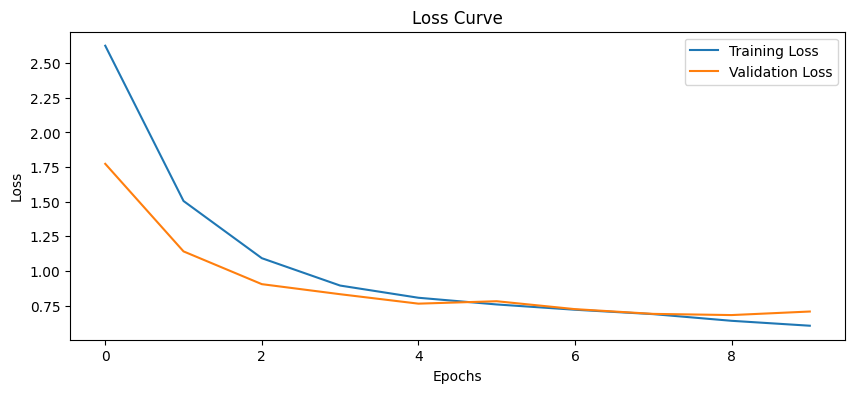

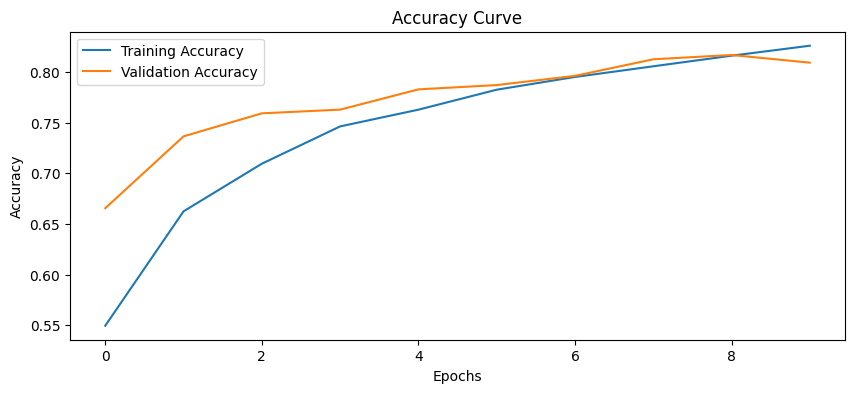

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert history to DataFrame for easy plotting
history_df = pd.DataFrame(history.history)

# Plot Loss Curve
plt.figure(figsize=(10, 4))
plt.plot(history_df["loss"], label="Training Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 4))
plt.plot(history_df["accuracy"], label="Training Accuracy")
plt.plot(history_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Convert true labels from one-hot to class indices
true_train_labels = np.argmax(train_labels, axis=1)
true_val_labels = np.argmax(val_labels, axis=1)

# Step 1: Get predictions on training set
train_predictions = model.predict(train_dataset)  # shape: (n_samples, 8)
train_preds_class = np.argmax(train_predictions, axis=1)

# Step 2: Get predictions on validation set
val_predictions = model.predict(val_dataset)  # shape: (n_samples, 8)
val_preds_class = np.argmax(val_predictions, axis=1)

# Step 3: Calculate metrics (average='weighted' handles class imbalance)
train_precision = precision_score(true_train_labels, train_preds_class, average='weighted')
train_recall = recall_score(true_train_labels, train_preds_class, average='weighted')
train_f1 = f1_score(true_train_labels, train_preds_class, average='weighted')
train_accuracy = accuracy_score(true_train_labels, train_preds_class)

val_precision = precision_score(true_val_labels, val_preds_class, average='weighted')
val_recall = recall_score(true_val_labels, val_preds_class, average='weighted')
val_f1 = f1_score(true_val_labels, val_preds_class, average='weighted')
val_accuracy = accuracy_score(true_val_labels, val_preds_class)

# Step 4: Print results
print("=== Training Metrics ===")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1 Score:  {train_f1:.4f}")
print(f"Training Accuracy:   {train_accuracy:.4f}")

print("\n=== Validation Metrics ===")
print(f"Precision: {val_precision:.4f}")
print(f"Recall:    {val_recall:.4f}")
print(f"F1 Score:  {val_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

207/207 ━━━━━━━━━━━━━━━━━━━━ 46s 195ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step
=== Training Metrics ===
Precision: 0.8599
Recall:    0.8570
F1 Score:  0.8567
Training Accuracy:   0.8570

=== Validation Metrics ===
Precision: 0.8212
Recall:    0.8169
F1 Score:  0.8175
Validation Accuracy: 0.8169


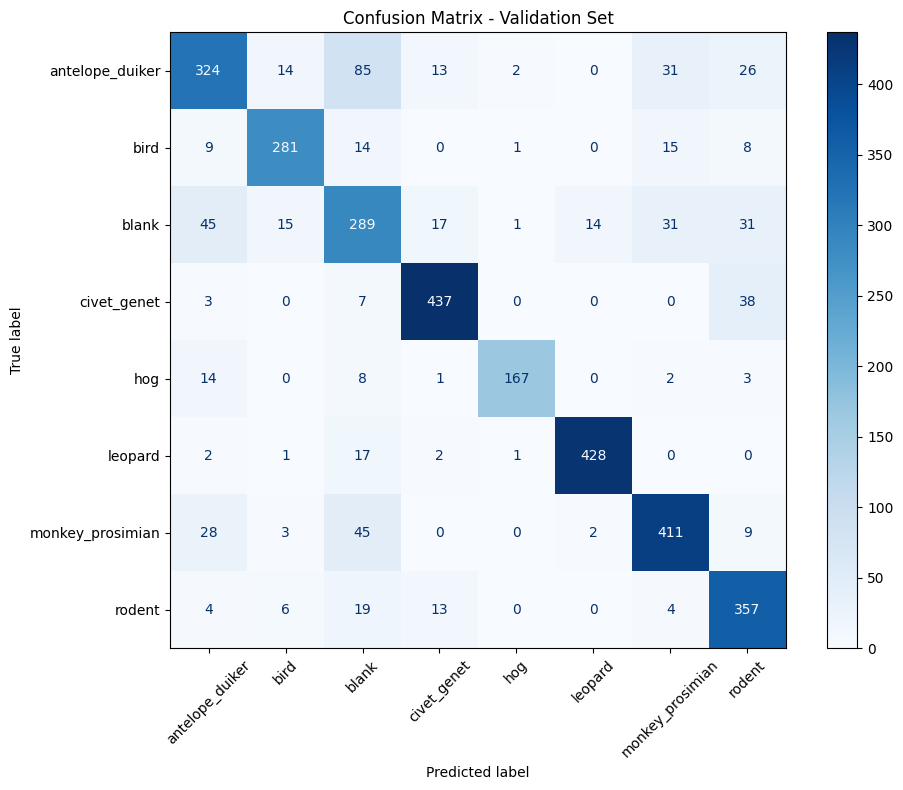

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(true_val_labels, val_preds_class)

# Define class names (update if your order is different)
class_names = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Validation Set")
plt.grid(False)
plt.tight_layout()
plt.show()

In [21]:
predictions = model.predict(test_dataset, verbose=1)  

70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step


In [22]:
test_ids = test_features["id"].values

# Apply softmax to ensure predictions are valid probabilities
# predictions = tf.nn.softmax(predictions, axis=1).numpy()

# Build the submission DataFrame
submission_df = pd.DataFrame(
    predictions,
    index=test_ids,
    columns=species_labels
)

# Reset index to include 'id' as a column
submission_df.reset_index(inplace=True)
submission_df.rename(columns={"index": "id"}, inplace=True)

# Load submission format to align rows & columns
submission_format = pd.read_csv("/kaggle/input/wildlife-classification/submission_format.csv")

# Confirm that columns are aligned correctly
assert list(submission_df.columns) == list(submission_format.columns), "Mismatch in column headers"
assert all(submission_df["id"] == submission_format["id"]), "Mismatch in image IDs"

# Save submission
submission_df.to_csv("/kaggle/working/submission_df.csv", index=False, encoding="utf-8")
print("submission_df.csv saved successfully.")

submission_df.csv saved successfully.


In [23]:
submission_df

id  antelope_duiker          bird         blank   civet_genet  \
0     ZJ016488     4.346713e-03  9.943385e-05  2.138413e-01  4.433460e-03   
1     ZJ016489     9.155422e-01  1.731282e-04  1.983970e-02  4.344091e-03   
2     ZJ016490     1.222868e-02  3.301638e-06  4.516527e-03  9.819816e-01   
3     ZJ016491     1.907679e-08  6.154435e-15  1.591306e-09  2.053670e-13   
4     ZJ016492     9.349082e-01  1.725919e-04  3.625632e-02  9.223490e-04   
...        ...              ...           ...           ...           ...   
4459  ZJ020947     7.735760e-02  1.647458e-03  7.252147e-01  7.834421e-05   
4460  ZJ020948     8.049898e-02  5.376212e-03  8.104827e-01  8.799335e-04   
4461  ZJ020949     5.114764e-02  7.305286e-05  2.555029e-01  6.341038e-01   
4462  ZJ020950     9.847236e-01  6.292261e-03  5.004772e-03  7.011291e-06   
4463  ZJ020951     4.146715e-05  1.369324e-06  9.854048e-04  2.157344e-07   

               hog   leopard  monkey_prosimian        rodent  
0     1.077629e-04  0.399354      1.369619e-05  3.778040e-01  
1     1.766333e-02  0.000443      2.934518e-02  1.264907e-02  
2     8.370912e-05  0.000029      5.282699e-04  6.291892e-04  
3     5.054728e-13  1.000000      1.758092e-13  6.825017e-12  
4     2.391074e-04  0.000130      2.020668e-02  7.164280e-03  
...            ...       ...               ...           ...  
4459  4.681443e-04  0.029663      1.544685e-01  1.110243e-02  
4460  2.377013e-03  0.006052      6.061117e-02  3.372196e-02  
4461  8.466707e-04  0.023509      5.642445e-05  3.476046e-02  
4462  6.649760e-04  0.000010      2.832803e-03  4.648074e-04  
4463  8.920729e-08  0.998969      3.289266e-08  2.235359e-06  

[4464 rows x 9 columns]